## Dataset

### Extracting dataset


In [0]:
!pip install patool
import os
from google.colab import drive
drive.mount('/content/drive')

# path do arquivo onde esta o dataset
dataset_zip_path = os.path.normpath('/content/drive/My Drive/datasets/motorcycle_detection.zip')

# path do arquivo onde o dataset será extraido
dataset_local_path = os.path.normpath('./dataset')

#path save models
models_path = os.path.normpath('/content/drive/My Drive/Desafios/desafio4/modelos')

INPUT_SIZE = (448, 448)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import sys, math, json
from PIL import Image, ImageDraw
from keras.preprocessing import image
import numpy as np
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from IPython.display import clear_output

# função para fazer o parse do json
def parse_json(file_path: str) -> (str, list):
  f = open(file_path)
  anot_dict = json.load(f)
  f.close()
  bboxes = []
  for bbox in anot_dict['bboxs']:
    bboxes.append(bbox)
  img_name = anot_dict['image']
  return img_name, bboxes 

# função para fazer o resize da bbox e da imagem
def resize_img_and_bboxes(img: Image, bboxes: list, factor: list) -> (Image, list):
  for i in range(len(bboxes)):
    bboxes[i] = [int(bboxes[i][0]*factor[1]),
                 int(bboxes[i][1]*factor[0]),
                 int(bboxes[i][2]*factor[1]),
                 int(bboxes[i][3]*factor[0])]
  img_width= int(np.shape(img)[1] * factor[1])
  img_height= int(np.shape(img)[0] * factor[0])
  return img.resize((img_width,img_height)), bboxes

# bounding box [x1,y1,x2,y2]
def jfile2dataset(file_path: str, imgdir_path: str, target_size: tuple = None) -> (Image, list):
  img_name, bboxes = parse_json(file_path)
  img = image.load_img(os.path.join(imgdir_path,img_name))
  for i in range(len(bboxes)):
    x1 = bboxes[i][0]
    y1 = bboxes[i][1]
    x2 = bboxes[i][2]+bboxes[i][0]
    y2 = bboxes[i][3]+bboxes[i][1]
    bboxes[i] = [x1,y1,x2,y2]
  if target_size:
    h,w, _ = np.shape(img)
    img_size = np.array([h,w])
    target_size = np.array(target_size)
    fscale = target_size/img_size
    img, bboxes = resize_img_and_bboxes(img, bboxes, fscale)
  return img, bboxes, img_name

def ascii_progress_bar(start, end, point, length, sufix='', prefix=''):
  percentage = min((point-start)/(end-start)*1.01, 1)
  string = '{:5.1f}/{:5.1f} |'.format(point-start,end-start)
  if percentage == 0:
    string += '.'*length
  elif percentage == 1:
    string += '='*length
  else:
    string += '='*int(percentage*length)+'>'+'.'*int((1-percentage)*length)
  string += '|{:6.1f}%'.format(percentage*100)
  sys.stdout.write('\r'+sufix+string+prefix)
  sys.stdout.flush()

Using TensorFlow backend.


### Load dataset

In [0]:
import patoolib
import os, sys, glob

try:
  os.mkdir(dataset_local_path)  
except FileExistsError as err:
  print(err)

if len(os.listdir(dataset_local_path)) == 0:
  patoolib.extract_archive(dataset_zip_path, outdir=dataset_local_path)
  clear_output()
  print("dataset extraido")
else:
  clear_output()
  print("dataset já extraido")
  
# path do arquivo onde estaram as imagens extraidas
imgdir_path = dataset_local_path+'/motorcycle_detection/images'
anotdir_path = dataset_local_path+'/motorcycle_detection/annotations'

input_files = glob.glob(os.path.join(anotdir_path,'*.json'))
valid_files = []
for i in range(len(input_files)):
  img_path, bboxs = parse_json(input_files[i])
  if len(bboxs) > 0:
    valid_files.append(input_files[i])
  ascii_progress_bar(0, len(input_files), i, 30, 'processando dados: ', '  | {} dados invalidos.'.format(i-len(valid_files)))
clear_output()
print('Num Samples:', len(input_files))
print('Num Valid Samples:', len(valid_files))

#Os dados serão divididos em 80% treino 10% validação e 10% teste
train_percentual = .80
train_files      = valid_files[0:int(len(valid_files)*train_percentual)]
validation_files = valid_files[int(len(valid_files)*train_percentual):]
print('train      {:5.2f}%: {} files'.format(len(train_files)*100./len(valid_files), len(train_files)))
print('validation {:5.2f}%: {} files'.format(len(validation_files)*100./len(valid_files), len(validation_files)))

Num Samples: 1654
Num Valid Samples: 1647
train      79.96%: 1317 files
validation 20.04%: 330 files


### Exemplo

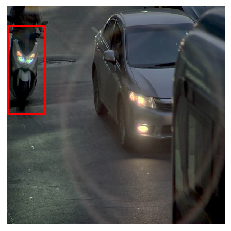

In [0]:
# Carregando imagem e anotação
img, bboxes, _ = jfile2dataset(np.random.choice(valid_files), imgdir_path, target_size=INPUT_SIZE)

#plotando imagem
ax = plt.subplot()
ax.imshow(img)
ax.axis('off')
#plotando bboxes
for bbox in bboxes:
  ax.add_patch(Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],\
                         linewidth=2, edgecolor='r', facecolor='none'))
plt.show()

## Data Augmentation

###Definition

In [0]:
ambient_paths = ['/content/drive/My Drive/pyutil']
for path in ambient_paths:
  if not path in sys.path:
    sys.path.insert(1,path)
from util.data_augmentation import data_augmentation

### Exemplo

brightness
horizontal_flip
zooming


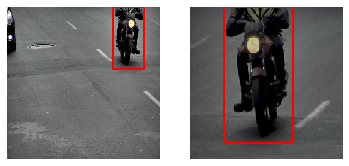

brightness
rotate
horizontal_flip
zooming


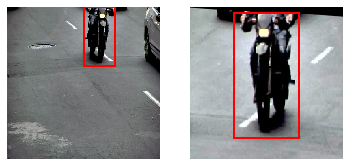

brightness
translate
zooming


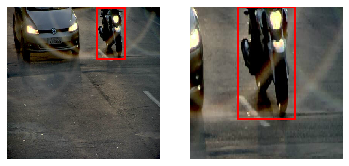

In [0]:
for i in range(3):
  # lendo a imagem  
  img, bboxes, _ = jfile2dataset(np.random.choice(valid_files), imgdir_path, target_size=INPUT_SIZE)
  #['zooming','horizontal_flip','rotate','brightness','cutout','translate'])
  img2 = Image.fromarray(np.asanyarray((np.ones(INPUT_SIZE+(3,))*255).astype('uint8')))
  nimg, nbboxes = data_augmentation([img, img2],
                                    bboxes,['zooming','horizontal_flip','rotate','brightness','translate'], vebose=1)
  fig, (ax1, ax2) = plt.subplots(1,2)
  ax1.axis('off'); ax2.axis('off')
  ax1.imshow(img)
  for bbox in bboxes:
    ax1.add_patch(Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                        linewidth=2,edgecolor='r', facecolor='none'))
  ax2.imshow(nimg[0])
  for bbox in nbboxes:
    ax2.add_patch(Rectangle((bbox[0],bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                                        linewidth=2,edgecolor='r', facecolor='none'))
  plt.show()

## Model

O modelo consiste de uma rede fully convolutional inspirada na CenterNet que recebe como entrada
uma imagem RGB (416, 416, 3) e tem como saida 3 featuremaps sendo o primeiro
um heatmap das localizaçoes dos objetos e os outros dois as dimensões de largura e altura da bounding box.
<br><br>
Entrada (RGB) -------- Saida: (posição) + (tamanho)
<br>
(416, 416, 3) --->(104, 104, 1)   +   (104,104,2)"w, h"
<br>
<br>
As imagens são geradas por um python generator contendo o esperado para a predição
de cada feature de saída + uma mascara que irá zerar os valores de w, h nas areas
dos feature maps que não tem relevancia para o treino, afim de facilitar o aprendizado
da rede.


### model definition

In [0]:
import tensorflow as tf
import keras.backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, Conv2DTranspose,\
                         BatchNormalization, Flatten, Dense, Lambda, UpSampling2D, Dropout,\
                         Concatenate, SpatialDropout2D, Multiply
from keras.layers.advanced_activations import LeakyReLU, ELU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop 
from keras.layers.merge import concatenate
from keras.losses import binary_crossentropy, mean_squared_error

def focal_loss(gamma=2., alpha=.25):
	def focal_loss_fixed(y_true, y_pred):
		pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
		pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
		return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
	return focal_loss_fixed

def smoothL1(delta=1):
  def smoothL1_fixed(y_true, y_pred):
    x   = K.abs(y_true - y_pred)
    x   = K.switch(x < delta, 0.5 * x ** 2, delta * (x - 0.5 * delta))
    return  K.sum(x)
  return smoothL1_fixed

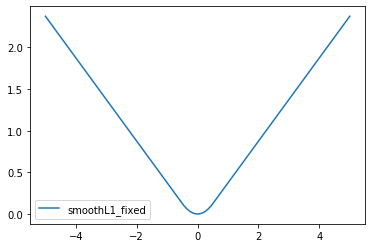

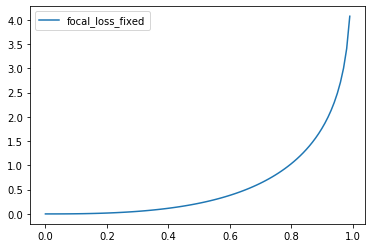

In [0]:
def visualize_loss(losses, min=-1, max=1, target=0):
  input_ = Input((1,))
  output_ = Activation('linear')(input_)
  f = Model(inputs=input_, outputs=output_)
  if not isinstance(losses, list):
    losses = [losses]
  for loss in losses:
    f.compile('adam', loss=loss)
    x = np.linspace(min,max,100)
    y = []
    for xi in x:
      y.append(f.evaluate([xi],[target],verbose=0))
    plt.plot(x,y,label=loss.__name__)
  plt.legend()
  plt.show()

visualize_loss(smoothL1(0.5), -5, 5)
visualize_loss(focal_loss(1.5, 0.1), 0, 1)

In [0]:
from keras.applications.resnet50 import ResNet50
from keras.applications.resnet50 import preprocess_input

# Rede Base
resNet = ResNet50(include_top=False, weights='imagenet',
                  input_tensor=None, input_shape=INPUT_SIZE+(3,))

In [0]:
model_input = resNet.input
backbone = resNet.layers[154].output  #14 512

skip = resNet.layers[80].output  #56 512

x = UpSampling2D((2,2), interpolation='bilinear')(backbone)        #28
x = Conv2D(512, (3, 3), strides=(1,1), padding='same')(x)  #28  
x = BatchNormalization()(x)
x = LeakyReLU()(x)

x = UpSampling2D((2,2), interpolation='bilinear')(x)       #56
x = Conv2D(1024, (3, 3), strides=(1,1), padding='same')(x)  #56  
x = BatchNormalization()(x)
x = Concatenate()([skip, x])
x = LeakyReLU()(x)

wh_owh = UpSampling2D((2,2), interpolation='bilinear')(x)
wh_owh = Conv2D(256, (3, 3), strides=(1,1), padding='same')(wh_owh)  #112 
wh_owh = BatchNormalization()(wh_owh)
wh_owh = LeakyReLU()(wh_owh)

wh = Conv2D(2, (3, 3), strides=(1,1), padding='same')(wh_owh)  #112 
wh = BatchNormalization()(wh)

owh = Conv2D(2, (3, 3), strides=(1,1), padding='same')(wh_owh)  #112 
owh = BatchNormalization()(owh)

pos = UpSampling2D((2,2), interpolation='bilinear')(x)       #112
pos = Conv2D(128, (3, 3), strides=(1,1), padding='same')(pos)  #112 
pos = BatchNormalization()(pos)
pos = LeakyReLU()(pos)

pos = Conv2D(64, (3, 3), strides=(1,1), padding='same')(pos)  #112 
pos = BatchNormalization()(pos)
pos = LeakyReLU()(pos)

pos = Conv2D(1, (3, 3), strides=(1,1), padding='same')(pos)  #112 
pos = BatchNormalization()(pos)

#x = Concatenate()([pos,wh,owh])
x = Activation('sigmoid')(pos)

for layer in resNet.layers:
  layer.trainable = False

model = Model(inputs=model_input, outputs=x)
model.compile(Adam(0.0005), mean_squared_error)
model.summary()

#OUTPUT
#out[0] pos_probability  pos
#out[1] width/out[1]     width
#out[2] height/out[2]    height
#out[3] 4/out[3]         offsetw
#out[4] 4/out[4]         offseth

Model: "model_24"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 448, 448, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 454, 454, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 224, 224, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 224, 224, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

###pre/pos prossessing

In [0]:
def pre_process(inputs: (np.ndarray, 'image[]', 'str[]'), input_size=INPUT_SIZE):
  if isinstance(inputs, (np.ndarray, list)):
    if isinstance(inputs[0], str):
      images = []
      for file_path in inputs:
        img_name, _ = parse_json(file_path)
        img = image.load_img(os.path.join(imgdir_path,img_name), target_size=input_size)
        img = img.resize(input_size)
        images.append(np.asarray(img))
      inputs = images
    inputs = np.asarray(inputs)
  else:
    inputs = np.asarray([np.asarray(inputs)])
  inputs_max = np.max(inputs)
  if inputs_max > 1:
    inputs = inputs/inputs_max
  return inputs

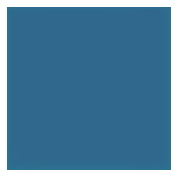

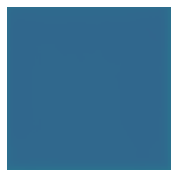

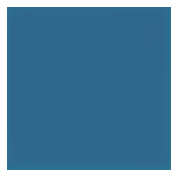

In [0]:
def plot_output(pred):
  for i in range(len(pred)):
    fig_size = 3
    channels = pred[0].shape[-1]
    fig, axes = plt.subplots(1,channels)
    if channels == 1: axes = [axes]
    fig.set_size_inches(fig_size*channels,fig_size)
    for j in range(channels):
      axes[j].axis('off');
      axes[j].imshow(pred[i,:,:,j], vmin=0, vmax=1)
    fig.show()
plot_output(model.predict(pre_process(valid_files[:3])))

In [0]:
def iou(boxA, boxB):
		xA = max(boxA[0], boxB[0])
		yA = max(boxA[1], boxB[1])
		xB = min(boxA[2], boxB[2])
		yB = min(boxA[3], boxB[3])
		interArea = max(0, xB - xA) * max(0, yB - yA)
		boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
		boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
		union = float(boxAArea + boxBArea - interArea)
		if union == 0: return 0
		iou = interArea / float(boxAArea + boxBArea - interArea)
		return iou

def compute_overlap(a, b):
  if len(a) == 0 or len(b) == 0:
    return np.zeros((max(len(a),1), max(len(b),1), 1))  
  area = (b[:, 2] - b[:, 0]) * (b[:, 3] - b[:, 1])
  iw = np.minimum(np.expand_dims(a[:, 2], axis=1), b[:, 2]) - np.maximum(np.expand_dims(a[:, 0], 1), b[:, 0])
  ih = np.minimum(np.expand_dims(a[:, 3], axis=1), b[:, 3]) - np.maximum(np.expand_dims(a[:, 1], 1), b[:, 1])
  iw = np.maximum(iw, 0)
  ih = np.maximum(ih, 0)
  ua = np.expand_dims((a[:, 2] - a[:, 0]) * (a[:, 3] - a[:, 1]), axis=1) + area - iw * ih
  ua = np.maximum(ua, np.finfo(float).eps)
  intersection = iw * ih
  return intersection / ua

def tp_fp_miss_match(pred_bboxes, gt_bboxes):
	if len(pred_bboxes) == 0:
		return [], [], gt_bboxes, []
	if len(gt_bboxes) == 0:
		return [], pred_bboxes, [], [] 
	gt_bboxes = np.array(gt_bboxes)
	overl = compute_overlap(pred_bboxes[:,:4], gt_bboxes)
	overlPG = np.max(overl, axis=1)
	overlGP = np.max(overl, axis=0)
	tp = pred_bboxes[overlPG >= 0.5, :]
	fp = pred_bboxes[overlPG <  0.5, :]
	miss = gt_bboxes[overlGP <  0.5]
	match = gt_bboxes[overlGP >=  0.5]
	return tp, fp, miss, match;

import matplotlib
def get_bboxs(prediction, k=30, min_score=0.3, max_overlap=0.5, level_res=14, clip_border=2):
	def center_of_mass(X):
		# calculate center of mass of a closed polygon
		x = X[:,0]
		y = X[:,1]
		g = (x[:-1]*y[1:] - x[1:]*y[:-1])
		A = 0.5*g.sum()
		cx = ((x[:-1] + x[1:])*g).sum()
		cy = ((y[:-1] + y[1:])*g).sum()
		return 1./(6*A)*np.array([cx,cy])
	def sort_by_score(bbox): 
				return bbox[4]
	factor = 4
	levels = np.linspace(0,1, level_res)
	batch_bboxes = []
	for bi in range(len(prediction[0])):	
		heat_map = prediction[0][bi][:,:,0].copy()

		if clip_border > 0:
			heat_map[:clip_border, :] = 0
			heat_map[-(clip_border+1):, :] = 0
			heat_map[:, :clip_border] = 0
			heat_map[:, -(clip_border+1):] = 0

		bboxes = []
		contour = plt.contour(heat_map, levels=levels)
		for segs in contour.allsegs:
			for seg in segs:
				cx, cy = center_of_mass(seg)
				i = max(min(int(round(cy)),heat_map.shape[0]-1),0)
				j = max(min(int(round(cx)),heat_map.shape[1]-1),0)
				score = prediction[0][bi][i,j,0]
				cx, cy = cx*factor, cy*factor
				w, h = prediction[1][bi][i,j,0], prediction[1][bi][i,j,1]
				x1, y1 = max(cx-w/2,0), max(cy-h/2,0)
				x2, y2 = min(cx+w/2,heat_map.shape[0]*factor-1), min(cy+h/2,heat_map.shape[0]*factor-1)
				bbox = [x1, y1, x2, y2, score]
				if bbox[4] > min_score:
					bboxes.append(bbox)
		if len(bboxes) > 0:
			bboxes.sort(key=sort_by_score, reverse=True)
			i, j = 0, 0
			while i < len(bboxes):
				j = i+1
				while j < len(bboxes):
					if iou(bboxes[i], bboxes[j]) >= max_overlap:
						bboxes.pop(j)
						j-=1
					j+=1
				i+=1
		plt.close()
		batch_bboxes.append(np.array(bboxes[0:min(k,len(bboxes))]))
	return np.array(batch_bboxes)

### batch generator

In [0]:
gauss_max_value = 0.3989422804014327
sqrt2pi = math.sqrt(2*math.pi)
def gauss_curve(sigma, x, u):
  t1 = 1.0/(sigma*sqrt2pi)
  return t1*math.e**(-(((x-u)/sigma)**2)/2)

def get_img_pos_prob(bboxes, in_shape, out_shape):
  img_mask = np.zeros(out_shape+(1,))
  sc = 6
  fx = in_shape[0]/out_shape[0]
  fy = in_shape[1]/out_shape[1]
  for bbox in bboxes:
    xc, yc = (bbox[0]+bbox[2])/(2*fx),  (bbox[1]+bbox[3])/(2*fy)
    xo, yo = xc-int(xc), yc-int(yc)
    w, h = (bbox[2]-bbox[0])/in_shape[0], (bbox[3]-bbox[1])/in_shape[1]
    if w > 0 and h > 0:
      for yi in range(img_mask.shape[0]):
        for xi in range(img_mask.shape[1]):
          gx = gauss_curve(sc, xi, int(xc))*sc/gauss_max_value
          gy = gauss_curve(sc, yi, int(yc))*sc/gauss_max_value
          value = gx*gy
          img_mask[yi,xi,0]+=value
          #if value > 0.1:
          #  img_mask[yi,xi,1] = w
          #  img_mask[yi,xi,2] = h
          #  img_mask[yi,xi,3] = xo
          #  img_mask[yi,xi,4] = yo
  return img_mask

def input_generator(input_files, imgdir_path, batch_size=None, apply_augmentation=False, return_bbox=False, endless=True):
    batch_x=[]
    batch_y=[]
    batch_b=[]
    replace = batch_size < len(input_files)
    epoch_files = np.random.choice(input_files, len(input_files), replace=replace)
    index = 0
    while 1:
      if index+batch_size > epoch_files.shape[0]:
        if endless:
          epoch_files = np.random.choice(input_files, len(input_files), replace=replace)
          index = 0
        else:
          batch_size = epoch_files.shape[0]-index
      for file_path in epoch_files[index:index+batch_size]:
        img, bboxes, img_name = jfile2dataset(file_path, imgdir_path, INPUT_SIZE)
        img = [img]
        if apply_augmentation:
          img, bboxes = data_augmentation(img, bboxes,['zooming','horizontal_flip','rotate','brightness','translate'])
        x = np.array(img[0])/255.0
        batch_x.append(x)
        batch_y.append(get_img_pos_prob(bboxes,INPUT_SIZE, (INPUT_SIZE[0]//4,INPUT_SIZE[1]//4)))
        batch_b.append(bboxes)
      if return_bbox:
        yield [np.asarray(batch_x), np.asarray(batch_y), np.asarray(batch_b)]
      else:
        yield [np.asarray(batch_x), np.asarray(batch_y)]
      index += batch_size
      if index == epoch_files.shape[0]: return
      batch_x.clear()
      batch_y.clear()
      batch_b.clear()

IndexError: ignored

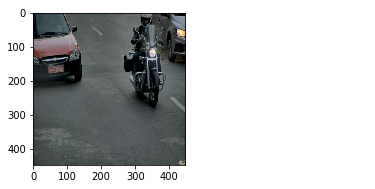

In [0]:
g = input_generator(train_files, imgdir_path, 3, apply_augmentation=False, return_bbox=True)
batch = g.__next__()
for i in range(len(batch[0])):
  fig_size = 3
  channels = batch[1].shape[-1]+1
  fig, axes = plt.subplots(1,channels)
  fig.set_size_inches(fig_size*channels,fig_size)
  axes[0].imshow(batch[0][i])
  for j in range(1,channels):
    axes[j].axis('off');
    axes[j].imshow(batch[1][i,:,:,j], vmin=0, vmax=1)
  for bbox in batch[2][i]:
    x, y, w, h = bbox[0], bbox[1], (bbox[2]-bbox[0]), (bbox[3]-bbox[1])
    cx, cy = (bbox[0]+bbox[2])//2, (bbox[1]+bbox[3])//2
    ax1.add_patch(Rectangle((x,y), w, h, linewidth=2,edgecolor='r', facecolor='none'))
  fig.show()

### training

In [0]:
model.predict()

In [0]:
batch_size = 12
epochs = 30
current_best = os.path.join(models_path,'best_model.hdf5')
final_detector = os.path.join(models_path,'detector_final.hdf5')

In [0]:
#Carreagando modelo
drive.mount('/content/drive')
#model=load_model(models_path+'/detector_final.hdf5', custom_objects={'focal_loss_fixed': focal_loss(),'smoothL1_fixed':smoothL1(0.5)})
#model.load_weights(models_path+'/detector_final.hdf5')
model.compile(loss=mean_squared_error, optimizer=Adam(0.001))
checkpoint = ModelCheckpoint(current_best, verbose=1, monitor='val_loss', save_best_only=True)  
history = model.fit_generator(input_generator(train_files, imgdir_path, batch_size, True), 
                              steps_per_epoch=int(len(train_files)/batch_size), 
                              epochs=epochs, 
                              callbacks=[checkpoint],
                              validation_data=input_generator(validation_files, imgdir_path, batch_size), 
                              validation_steps=int(len(validation_files)/batch_size))

Mounted at /content/drive
Epoch 1/30
109/109 [==============================] - 240s 2s/step - loss: 0.2011 - val_loss: 0.1524

Epoch 00001: val_loss improved from inf to 0.15238, saving model to /content/drive/My Drive/Desafios/desafio4/modelos/best_model.hdf5
Epoch 2/30
109/109 [==============================] - 228s 2s/step - loss: 0.1738 - val_loss: 0.1363

Epoch 00002: val_loss improved from 0.15238 to 0.13633, saving model to /content/drive/My Drive/Desafios/desafio4/modelos/best_model.hdf5
Epoch 3/30
 25/109 [=====>........................] - ETA: 2:41 - loss: 0.1596

KeyboardInterrupt: ignored

In [0]:
drive.mount('/content/drive')
model=load_model(current_best, custom_objects={'focal_loss_fixed': focal_loss(),'smoothL1_fixed':smoothL1(0.5)})
model.load_weights(current_best)
model.evaluate_generator(input_generator(validation_files, imgdir_path, batch_size, False),
                         steps=int(len(validation_files)/batch_size))

In [0]:
"""
model.load_weights(current_best)
model.save(models_path+'/detector_final.hdf5')
"""

### Evaluating

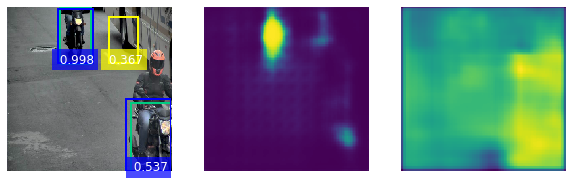

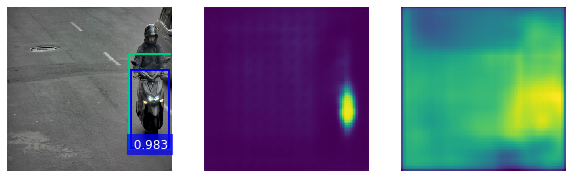

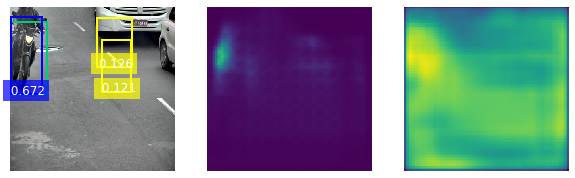

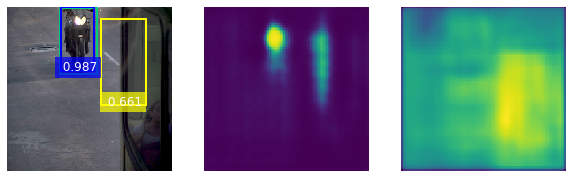

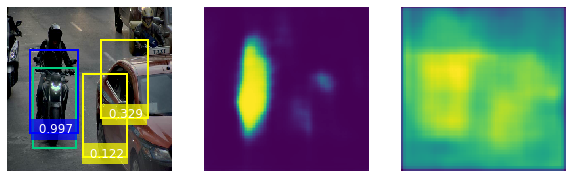

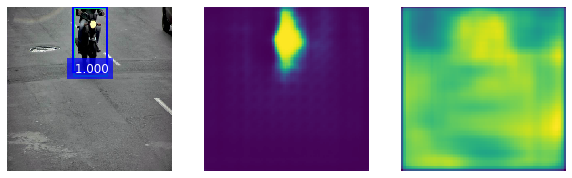

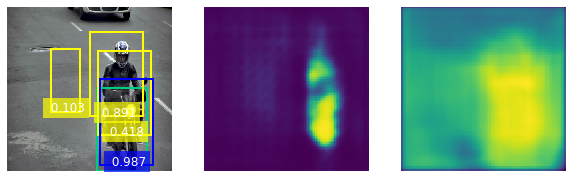

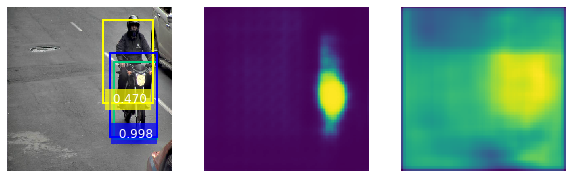

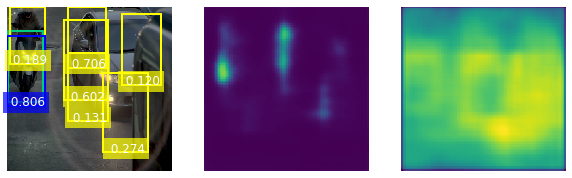

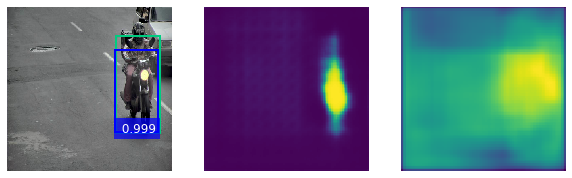

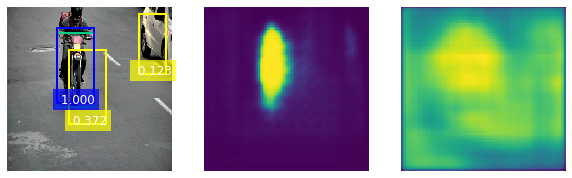

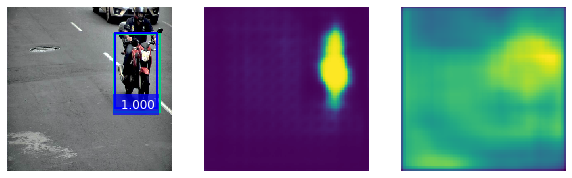

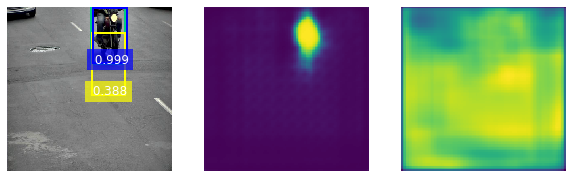

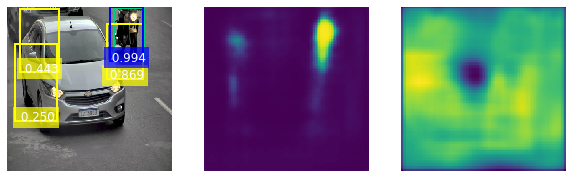

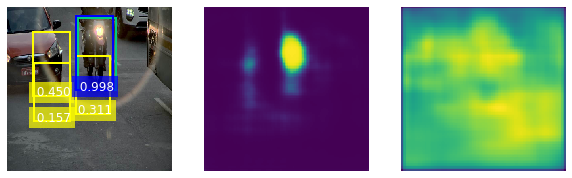

In [0]:
from matplotlib.patches import Rectangle
def plot_bboxes(preds, color=(0,0,1), axis=None):
  axis = axis if axis else plt.gca()
  for pred in preds:
    rect = Rectangle((pred[0], pred[1]), pred[2]-pred[0], pred[3]-pred[1],
                                      linewidth=2, edgecolor=color, facecolor='none')
    axis.add_patch(rect)
    if len(pred) >= 5:
      score = pred[4]
      label = ''
      if len(pred) >= 6:
        label = labels_to_names[pred[5]]
      axis.text((pred[0]+pred[2])/2, pred[3],'{} {:.3f}'.format(label, score),fontsize=12, color='w',
              horizontalalignment='center', bbox=dict(facecolor=color+(0.7,), edgecolor='none'))

def print_prediction(img, pred_bboxes, true_bboxes=None, predictions=None):
  for i in range(len(pred_bboxes)):
    if predictions is not None:
      fig, (ax1, ax2, ax3) = plt.subplots(1,3)
      fig.set_size_inches(10,4)
      ax2.axis('off'); ax3.axis('off')
      ax2.imshow(predictions[0][i][:,:,0], vmin=0, vmax=1)
      ax3.imshow(predictions[1][i][:,:,1])
    else:
      fig, ax1 = plt.subplots(1,1)
    ax1.axis('off')
    ax1.imshow(img[i])
    if not true_bboxes is None:
      tp, fp, miss, match = tp_fp_miss_match(pred_bboxes[i], true_bboxes[i])
      plot_bboxes(match, (0,.8,.5), ax1)
      plot_bboxes(miss, (1,0,0), ax1)
      plot_bboxes(fp, (1,1,0), ax1)
      plot_bboxes(tp, (0,0,1), ax1)
    else:
      plot_bboxes(pred_bboxes[i], (0,0.2,1), ax1)
    plt.show()

#drive.mount('/content/drive')
#model.load_weights(final_detector)
test_generator = input_generator(validation_files, imgdir_path, 15, apply_augmentation=False, return_bbox=True)
((img, _), y, bboxes) = test_generator.__next__()
preds = model.predict(pre_process(img))
print_prediction(img, get_bboxs(preds, 100, 0.1), bboxes, preds)

In [0]:
drive.mount('/content/drive')
internet_img_test = glob.glob('/content/drive/My Drive/Desafios/desafio4/dataset/visual_test/*.*')
imgs = pre_process(internet_img_test)
preds = model.predict(imgs)
print_prediction(imgs[0], get_bboxs(preds, 100, 0.1, 0.3), predictions=preds)

##Curva ROC

Realizando predições

In [0]:
def roc_curve(file_paths, img_path, score_samples=100, nms=0.5):
  tp = []
  fp = []
  gt_count = 0
  for i in range(len(file_paths)):
    img, gt_boxes, _ = jfile2dataset(file_paths[i], img_path, INPUT_SIZE)
    gt_boxes = np.array(gt_boxes)
    preds = model.predict(pre_process(img))
    bboxes = get_bboxs(preds,300,0,0.4,100)[0]
    if len(gt_boxes) == 0:
      fp.extend(bboxes[:, 4].tolist())
    else:
      overl = compute_overlap(bboxes[:,:4], gt_boxes)
      overl = np.max(overl, axis=1)
      tp.extend(bboxes[overl >= 0.5, 4].tolist())
      fp.extend(bboxes[overl <  0.5, 4].tolist())
      gt_count += len(gt_boxes)
    ascii_progress_bar(0, len(file_paths), i, 30)
  tp = np.array(tp)
  fp = np.array(fp)
  fppi = []
  miss_rate = []
  for score in np.linspace(0, 1, score_samples):
    fppi.append(len(fp[fp >= score])/len(file_paths))
    if gt_count > 0:
      miss_rate.append(1-(len(tp[tp >= score])/gt_count))
    else:
      miss_rate.append(0)
  return np.array(fppi), np.array(miss_rate)

329.0/330.0 |==============================| 100.0%

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  


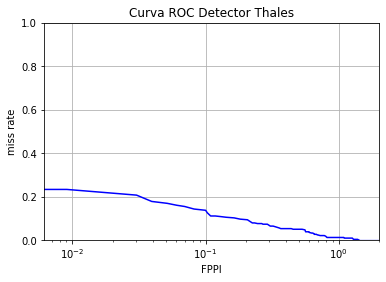

In [0]:
fppi, miss_rate = roc_curve(validation_files, imgdir_path)
fig, ax1 = plt.subplots(1,1)
ax1.set_title('Curva ROC Detector Thales')
ax1.plot(fppi, miss_rate, color='blue')
ax1.set_xscale('log')
ax1.grid(True)
ax1.set_ylim(0,1)
ax1.set_xlim(0,2)
ax1.set_ylabel('miss rate')
ax1.set_xlabel('FPPI')
fig.show()

##Load teste dataset

In [0]:
import shutil
drive.mount('/content/drive')

test_imgdir = os.path.normpath('/content/drive/My Drive/datasets/com_moto')
target_files = ['/content/drive/My Drive/datasets/Motos_DetA.zip','/content/drive/My Drive/datasets/Motos_DetB.zip']
dataset_test_local_path = os.path.join(dataset_local_path, 'test')
for files in target_files:    
  # downloading the file to your Google Colab space
  if not os.path.exists(dataset_test_local_path):
    try:
      os.makedirs(dataset_test_local_path)
    except: pass
    print('Extracting the file to %s' % dataset_test_local_path)
    patoolib.extract_archive(files, outdir=dataset_test_local_path)

try:
  os.makedirs(os.path.join(dataset_test_local_path, 'files'))
except: pass

target_folders = ['Imagens anotadas - Misael','']
for folder in target_folders:
  folder_path = os.path.join(dataset_test_local_path, folder)
  for filename in glob.glob(os.path.join(folder_path,'*.json')):
    dest = os.path.join(dataset_test_local_path, 'files', os.path.basename(filename))
    shutil.move(filename, dest)  

from IPython.display import clear_output
input_files = glob.glob(os.path.join(dataset_test_local_path, 'files/*.json'))
test_files = []
for i in range(len(input_files)):
  img_path, bboxs = parse_json(input_files[i])
  if len(bboxs) > 0 and os.path.exists(os.path.join(test_imgdir,img_path)):
    test_files.append(input_files[i])
  ascii_progress_bar(0, len(input_files), i, 30, 'processando dados: ', '  | {} dados invalidos.'.format(i-len(test_files)))
clear_output()
print('Num Samples:', len(test_files))

Num Samples: 1281


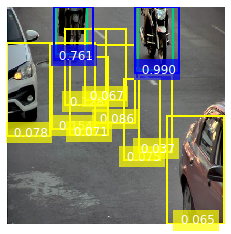

In [0]:
# preprocess image for network
#Prediction
test_generator = input_generator(test_files, test_imgdir, 1, apply_augmentation=False, return_bbox=True)
((img, _), y, gt_boxes) = test_generator.__next__()
preds = model.predict(pre_process(img))
bboxes = get_bboxs(preds,100,0,0.4,28)
print_prediction(img, bboxes, gt_boxes)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
1280.0/1281.0 |==============================| 100.0%

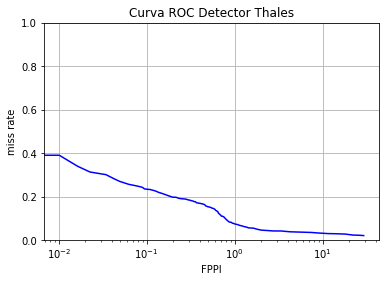

In [0]:
drive.mount('/content/drive')
fppi, miss_rate = roc_curve(test_files, test_imgdir)
fig, ax1 = plt.subplots(1,1)
ax1.set_title('Curva ROC Detector Thales')
ax1.plot(fppi, miss_rate, color='blue')
ax1.set_xscale('log')
ax1.grid(True)
ax1.set_ylim(0,1)
ax1.set_ylabel('miss rate')
ax1.set_xlabel('FPPI')
fig.show()